**Laptop Price Prediction Using Linear Regression**
*Introduction*
This project aims to build a linear regression model to predict laptop prices based on various features such as brand, processor, RAM, hard drive type, screen size, and others. The dataset used in this project is sourced from Kaggle and includes a wide range of information on laptop specifications and their prices.

*Data Source*
The dataset for this project is sourced from the following link:
https://www.kaggle.com/datasets/muhammetvarl/laptop-price/discussion/361977.
This dataset contains detailed specifications and pricing information for laptops, making it an ideal candidate for regression analysis.

*Project Objective*
The primary objective of this project is to understand how various laptop features influence their prices and to build an effective linear regression model that can be used to predict the prices of laptops based on their specifications. This model could be beneficial for consumers seeking pricing guidance and for vendors in setting competitive prices for their products.

*Methodology*
This project follows a systematic approach to build and evaluate a linear regression model for predicting laptop prices. The methodology includes several key steps, as outlined below:

* Data Cleaning
- Handling Missing Data: Identify and address missing values in the dataset. Missing data can significantly affect regression analysis. Options for handling missing data include imputation (filling in missing values with statistical measures like mean or median) or removal of records with missing values.
- Outlier Detection and Removal: Identify and eliminate outliers, which are data points significantly different from others. Outliers can distort the analysis and model performance. Techniques such as Z-score and IQR (Interquartile Range) can be used for outlier detection.
* Feature Encoding
- Categorical Variables: Categorical variables cannot be directly used in regression models. Encoding techniques, such as one-hot encoding, are applied to transform these variables into a numerical format. This process involves creating additional binary (0 or 1) columns for each category of the variable.
* Variable Normalization
- Standardization: Ensure that numeric variables are standardized, which means they are scaled to have a mean of 0 and a standard deviation of 1. Standardization helps in comparing the influence of different variables on the model and can improve the convergence of gradient-based optimization algorithms used in model training.
* Predictions Using Different Models
- Model Exploration: Besides linear regression, explore other regression models to compare performances. Common alternatives include Ridge Regression, Lasso Regression, and Polynomial Regression. This comparative analysis can help in identifying the most suitable model for predicting laptop prices based on the given features.
* Model Evaluation
- Use appropriate metrics to evaluate the performance of the regression models. Common metrics include Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R² (Coefficient of Determination). These metrics provide insights into the accuracy and reliability of the predictions.

**Reading Data**

In [48]:
import pandas as pd

df = pd.read_csv('laptop_price.csv', encoding='latin-1')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


**Preprocessing data**


In [49]:
brand_counts = df['Company'].value_counts()
small_brands = brand_counts[brand_counts < 10].index
df['Company'] = df['Company'].apply(lambda x: "Others" if x in small_brands else x)

df['OpSys'] = df['OpSys'].replace({'Windows 10 S': 'Windows 10', 'Mac OS X': 'macOS'})
df['OpSys'] = df['OpSys'].replace(['Chrome OS', 'Android'], 'OtherSys')
df['Memory_Type'] = df['Memory'].str.extract(r'(SSD|HDD|Flash Storage)', expand=False)
import re
def convert_to_gb(value):
    unit_map = {'TB': 1024, 'GB': 1}
    match = re.search(r'(\d+)(TB|GB)', value, re.IGNORECASE)
    if match:
        num, unit = match.groups()
        return float(num) * unit_map[unit.upper()]
    return None

def trim_processor(value):
    if value.startswith('Intel'):
        return ' '.join(value.split(' ', 3)[:3])
    else:
        return ' '.join(value.split(' ', 2)[:2])
df[['Processor', 'Clock']] = df['Cpu'].apply(lambda x: pd.Series(str(x).rsplit(' ', 1)))
df['Processor'] = df['Processor'].apply(trim_processor)
cpu_counts = df['Processor'].value_counts()
rare_cpu = cpu_counts[cpu_counts < 10].index
df['Processor'] = df['Processor'].apply(lambda x: "Others" if x in rare_cpu else x)
df['Clock'] = df['Clock'].apply(lambda x: float(str(x).strip("GHz")))

df['Memory_size_GB'] = df['Memory'].apply(convert_to_gb)
df['Ram'] = df["Ram"].apply(lambda x: int(str(x).strip("GB")))
df['Weight'] = df["Weight"].apply(lambda x: float(str(x).strip("kg")))

df['Gpu_Brand'] = df['Gpu'].str.split(n=1, expand=True)[0]

df['Screen_Width'] = df['ScreenResolution'].str.rsplit(' ', n=1).str[-1].str.split('x').str[0].astype(int)
df = df.drop(['laptop_ID', 'Product', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu'], axis=1)
df.head()

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Memory_Type,Processor,Clock,Memory_size_GB,Gpu_Brand,Screen_Width
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,SSD,Intel Core i5,2.3,128.0,Intel,2560
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,Flash Storage,Intel Core i5,1.8,128.0,Intel,1440
2,HP,Notebook,15.6,8,No OS,1.86,575.00,SSD,Intel Core i5,2.5,256.0,Intel,1920
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,SSD,Intel Core i7,2.7,512.0,AMD,2880
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,SSD,Intel Core i5,3.1,256.0,Intel,2560


**Cleaning data**

In [50]:
any_nan = df.isnull().values.any()
any_nan

True

In [51]:
df.dropna()
df.drop_duplicates(keep='first', inplace=True)

def remove_outliers(df, columns):
    indices_to_remove = set()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        indices_to_remove.update(outliers_indices)

    df_cleaned = df.drop(indices_to_remove)

    return df_cleaned
df = remove_outliers(df, ['Price_euros', "Inches"])

**Splitting data**

In [52]:
from sklearn.model_selection import train_test_split

X = df.drop('Price_euros', axis=1)
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

**One Hot Encoding**

In [53]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
df_encoded = df.copy()
columns_to_encode=['Company','TypeName', 'OpSys', 'Memory_Type', 'Gpu_Brand', "Processor"]
encoder.fit(X_train[columns_to_encode])

X_train_encoded = encoder.transform(X_train[columns_to_encode])
X_test_encoded = encoder.transform(X_test[columns_to_encode])

X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode), index=X_test.index)

X_train_dropped = X_train.drop(columns=columns_to_encode)
X_test_dropped = X_test.drop(columns=columns_to_encode)

X_train_final = pd.concat([X_train_dropped, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_dropped, X_test_encoded_df], axis=1)

In [54]:
X_train_final.dtypes

Inches                          float64
Ram                               int64
Weight                          float64
Clock                           float64
Memory_size_GB                  float64
Screen_Width                      int32
Company_Acer                    float64
Company_Apple                   float64
Company_Asus                    float64
Company_Dell                    float64
Company_HP                      float64
Company_Lenovo                  float64
Company_MSI                     float64
Company_Others                  float64
Company_Toshiba                 float64
TypeName_2 in 1 Convertible     float64
TypeName_Gaming                 float64
TypeName_Netbook                float64
TypeName_Notebook               float64
TypeName_Ultrabook              float64
TypeName_Workstation            float64
OpSys_Linux                     float64
OpSys_No OS                     float64
OpSys_OtherSys                  float64
OpSys_Windows 10                float64


**Normalization**

In [55]:
mean_values = X_train_final.mean()
std_values = X_train_final.std()

print("Średnie wartości dla każdej kolumny:\n", mean_values)
print("\nOdchylenia standardowe dla każdej kolumny:\n", std_values)

Średnie wartości dla każdej kolumny:
 Inches                            15.115202
Ram                                8.297828
Weight                             2.035975
Clock                              2.321158
Memory_size_GB                   444.624612
Screen_Width                    1911.385729
Company_Acer                       0.074457
Company_Apple                      0.012410
Company_Asus                       0.113754
Company_Dell                       0.241986
Company_HP                         0.207859
Company_Lenovo                     0.224405
Company_MSI                        0.047570
Company_Others                     0.040331
Company_Toshiba                    0.037229
TypeName_2 in 1 Convertible        0.085832
TypeName_Gaming                    0.162358
TypeName_Netbook                   0.004137
TypeName_Notebook                  0.569804
TypeName_Ultrabook                 0.158221
TypeName_Workstation               0.019648
OpSys_Linux                        0.0

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_final)
X_train_scaled = scaler.transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns, index=X_test_final.index)

mean_values = X_train_scaled_df.mean()
std_values = X_train_scaled_df.std()
print("Średnie wartości dla każdej kolumny:\n", mean_values)
print("\nOdchylenia standardowe dla każdej kolumny:\n", std_values)

Średnie wartości dla każdej kolumny:
 Inches                         -6.245722e-17
Ram                            -8.450095e-17
Weight                         -2.204372e-16
Clock                          -1.160051e-15
Memory_size_GB                 -1.469582e-17
Screen_Width                    1.781868e-16
Company_Acer                   -1.469582e-17
Company_Apple                   4.408745e-17
Company_Asus                    2.571768e-17
Company_Dell                   -4.316896e-17
Company_HP                     -1.928826e-17
Company_Lenovo                  1.469582e-17
Company_MSI                     5.878327e-17
Company_Others                 -5.878327e-17
Company_Toshiba                 1.469582e-17
TypeName_2 in 1 Convertible    -8.817490e-17
TypeName_Gaming                 1.653279e-17
TypeName_Netbook                4.041350e-17
TypeName_Notebook               1.653279e-17
TypeName_Ultrabook              1.102186e-17
TypeName_Workstation           -2.939163e-17
OpSys_Linux      

**Regression**

In [57]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled_df, y_train)
y_pred_linear = linear_model.predict(X_test_scaled_df)
print(f'Coefficients: {linear_model.coef_}')

Coefficients: [-3.37251486e+01  2.09219348e+02  7.15532144e+01  7.41182983e+01
  9.27125328e+00  9.30868918e+01 -1.72555540e+15  2.21806023e+15
 -2.08707422e+15 -2.81521168e+15 -2.66724896e+15 -2.74227901e+15
 -1.39913581e+15 -1.29317539e+15 -1.24444937e+15 -1.33267125e+14
 -1.75448713e+14 -3.05352155e+13 -2.35548485e+14 -1.73626403e+14
 -6.60296233e+13 -4.05311980e+15 -4.34705442e+15 -2.06246953e+15
 -7.05985539e+15 -3.53095888e+15 -5.09879748e+15  1.44414892e+14
  3.48041522e+14  3.62069061e+14  6.07165827e+13 -2.46392041e+15
 -2.26411473e+14 -3.51095388e+15 -3.27620682e+15  3.73373607e+14
  4.47801423e+14  7.26242373e+14  4.12348952e+14  1.22969243e+15
  1.83951558e+15  1.91635894e+15  5.39660430e+14  7.92565416e+14]


In [58]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled_df, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled_df)
print(f'Coefficients: {lasso_model.coef_}')


Coefficients: [-30.46203186 210.58291601  62.63896834  74.18523105   4.16864675
  94.0500474  -27.24750005   3.64979284 -10.49116102  -0.
  10.25806799  -0.66527473  38.93955585   0.93162198  20.56812003
  20.37284183  -5.1981269   16.85893985 -64.18788479  69.15133901
  70.35968227 -21.55753758 -42.4022147    6.07826785   0.
  49.5273321    1.68844786   0.         -18.78999096  51.65157818
 -14.85813582 -23.84501323  -3.35707435  37.25196881  -0.
 -22.50693979 -23.8251968  -24.44215632  13.2900256  -40.83881991
   0.          55.95047295  -8.35293643 -36.65481163]


In [59]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled_df, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled_df)
print(f'Coefficients: {ridge_model.coef_}')


Coefficients: [-36.5283823  208.13674826  74.01804983  75.30833574   9.53071744
  94.40572102 -30.51599616   3.24469175 -12.66654294  -4.27279664
   7.67389855  -5.22963934  40.00429025   1.19797237  20.18007328
  18.10968627 -14.15506351  16.5245543  -69.75770867  65.86241359
  69.08035226 -19.0536285  -39.38210285   9.00997064   5.27301035
  52.57136044   3.24469175  -3.98246717 -35.82695187  38.98824995
 -17.65653736 -29.72444902  -5.5953498   29.38101326  -8.74482469
 -23.11083149 -24.3940647  -24.61897702  14.16485356 -40.53216535
   2.33883336  58.16002152  -8.83519552 -37.2922429 ]


In [60]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train_scaled_df)
X_test_poly = poly_features.transform(X_test_scaled_df)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
print(f'Coefficients: {poly_model.coef_}')



Coefficients: [-3.27619240e+11  1.18851405e+10  1.81788108e+11 ... -7.16220047e+09
  1.30264084e+09 -2.33247382e+10]


In [61]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_scaled_df, y_train)
y_pred_tree = tree_model.predict(X_test_scaled_df)


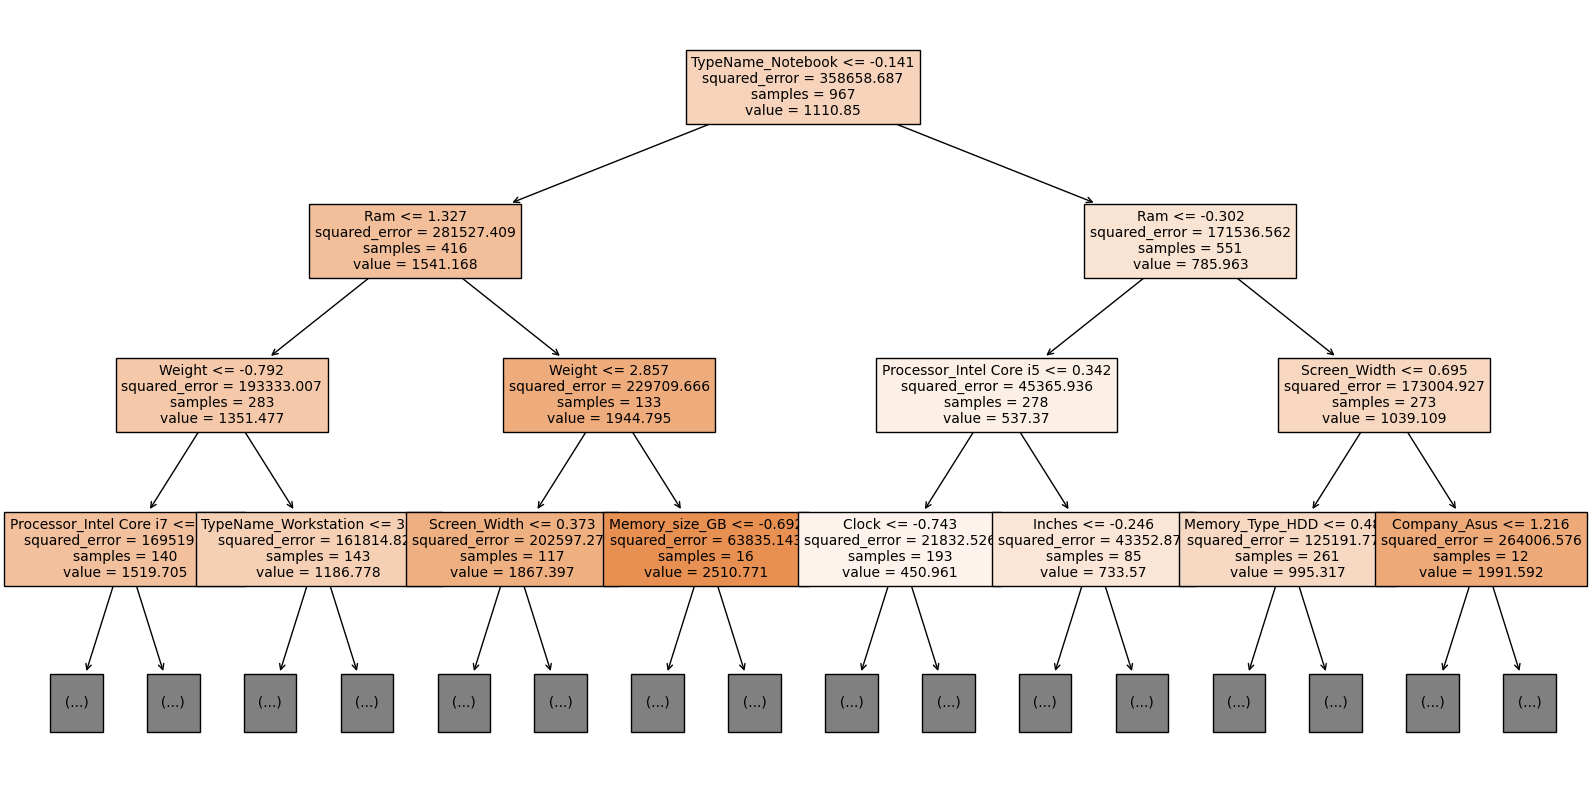

In [62]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=X_test_scaled_df.columns, max_depth=3, fontsize=10)
plt.show()


**Evaluation**

In [63]:
from sklearn.metrics import r2_score, mean_squared_error
model_names = ['Linear', 'Lasso', 'Ridge', 'Polynomial', 'Decision Tree']
predictions = [y_pred_linear, y_pred_lasso, y_pred_ridge, y_pred_poly, y_pred_tree]
results = []

for model_name, pred in zip(model_names, predictions):
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    results.append({"Model": model_name, "MSE": mse, "R2": r2})

results_df = pd.DataFrame(results)

In [64]:
results_df

,Model,MSE,R2
0,Linear,7.439107e+04,7.725255e-01
1,Lasso,7.408979e+04,7.734468e-01
2,Ridge,7.398889e+04,7.737553e-01
3,Polynomial,2.125426e+24,-6.499168e+18
4,Decision Tree,1.189689e+05,6.362147e-01



In our analysis, the Ridge, Lasso, and Linear Regression models demonstrated the best performance and achieved comparable results. Among these, the Ridge Regression model emerged as the top performer, indicating its effectiveness in handling the dataset and predicting laptop prices with a high level of accuracy. On the other hand, the Polynomial Regression model did not perform as well, showing significantly lower effectiveness in this particular case. This outcome suggests that while Polynomial Regression can be powerful for capturing non-linear relationships, it may not always be the most suitable choice, especially if the data does not exhibit strong non-linear patterns or if the model becomes too complex and overfits the data.